In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import pyro

/home/aqoku/miniconda3/envs/cellij/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")

In [4]:
import cellij
from cellij.core.synthetic import DataGenerator
from cellij.core.models import MOFA

In [5]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7ff8a3705570>


In [6]:
# plotting functions
def _lines(ax, positions, ymin, ymax, horizontal=False, **kwargs):
    if horizontal:
        ax.hlines(positions, ymin, ymax, **kwargs)
    else:
        ax.vlines(positions, ymin, ymax, **kwargs)
    return ax


def lined_heatmap(data, figsize=None, hlines=None, vlines=None, **kwargs):
    """Plot heatmap with horizontal or vertical lines."""
    if figsize is None:
        figsize = (20, 2)
    fig, g = plt.subplots(figsize=figsize)
    g = sns.heatmap(data, ax=g, **kwargs)
    if hlines is not None:
        _lines(
            g,
            hlines,
            *sorted(g.get_xlim()),
            horizontal=True,
            lw=1.0,
            linestyles="dashed",
        )
    if vlines is not None:
        _lines(
            g,
            vlines,
            *sorted(g.get_ylim()),
            horizontal=False,
            lw=1.0,
            linestyles="dashed",
        )
    return g

In [7]:
# random seed to use throughout the notebook
seed = 123

# basic parameters
n_samples = 200
n_features = [400, 400, 400]
n_views = len(n_features)
likelihoods = ["Normal" for _ in range(n_views)]

# more specific parameters to the structure of the latent factors
n_fully_shared_factors = 2
n_partially_shared_factors = 15
n_private_factors = 3

# optional: number of covariates to generate
n_covariates = 0

In [8]:
dg = DataGenerator(
    n_samples,
    n_features,
    likelihoods,
    n_covariates=n_covariates,
)

rng = dg.generate(seed=seed)

# center data
dg.normalize(with_std=False)

Using a uniform distribution with parameters 0.05 and 0.15 for generating the number of active factor loadings.


In [9]:
feature_offsets = [0] + np.cumsum(n_features).tolist()
vlines = feature_offsets[1:-1]

<Axes: >

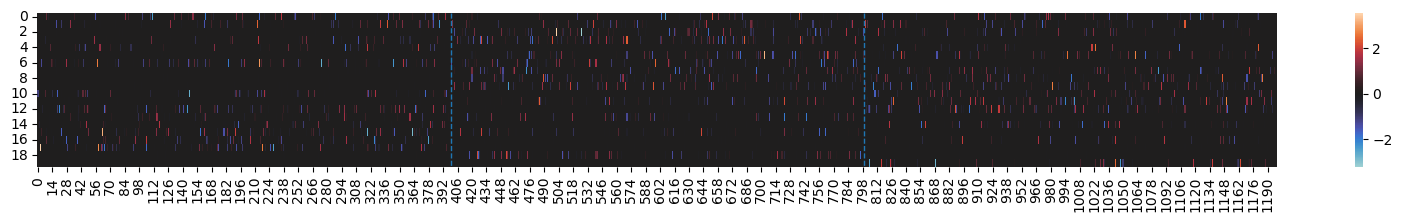

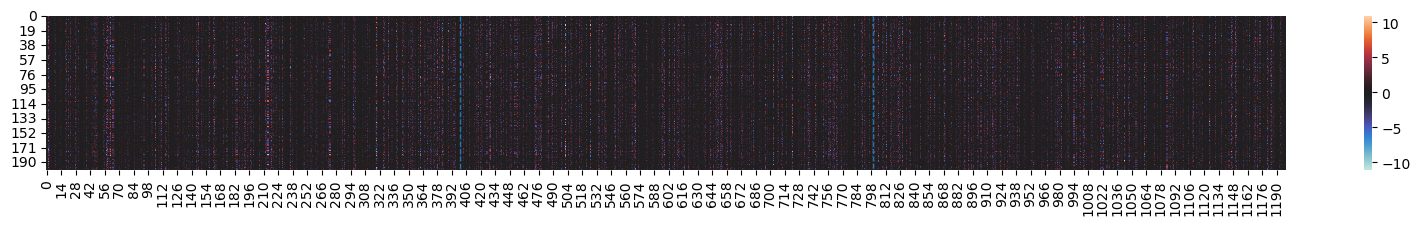

In [10]:
# factor loadings should be fairly sparse
lined_heatmap(dg.w, vlines=vlines, center=0)
lined_heatmap(dg.y, vlines=vlines, center=0)

In [11]:
mdata = dg.to_mdata()
mdata

MuData object with n_obs × n_vars = 200 × 1200
  obsm:	'z'
  3 modalities
    feature_group_0:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_1:	200 x 400
      varm:	'w', 'w_mask'
    feature_group_2:	200 x 400
      varm:	'w', 'w_mask'

In [12]:
model = MOFA(n_factors=dg.n_factors, sparsity_prior="Horseshoe", guide="AutoNormal", init_scale=0.01)
model.add_data(data=mdata, na_strategy=None)
model._data._values = torch.Tensor(np.concatenate([mdata[key].X for key in mdata.mod.keys()], axis=1))

In [13]:
model.fit(likelihoods=mdata.uns['likelihoods'],  learning_rate=0.005, epochs=10000, verbose_epochs=500, min_delta=0.0000001)

Epoch      0:       64643.70 	
Epoch    500:       35138.15 	|  45.64%	|  20.51s
Epoch   1000:       33518.14 	|   4.61%	|  22.47s
Epoch   1500:       33013.77 	|   1.50%	|  22.70s
Epoch   2000:       32799.39 	|   0.65%	|  22.61s
Epoch   2500:       32694.72 	|   0.32%	|  22.62s
Epoch   3000:       32641.86 	|   0.16%	|  22.77s
Epoch   3500:       32615.15 	|   0.08%	|  22.60s
Epoch   4000:       32601.05 	|   0.04%	|  22.67s
Epoch   4500:       32593.52 	|   0.02%	|  22.63s
Epoch   5000:       32588.54 	|   0.02%	|  22.70s
Epoch   5500:       32585.58 	|   0.01%	|  22.54s
Epoch   6000:       32583.03 	|   0.01%	|  22.56s
Epoch   6500:       32581.23 	|   0.01%	|  22.72s
Epoch   7000:       32579.47 	|   0.01%	|  22.55s
Epoch   7500:       32577.95 	|   0.00%	|  22.57s
Epoch   8000:       32576.70 	|   0.00%	|  22.55s
Epoch   8500:       32575.28 	|   0.00%	|  22.80s
Epoch   9000:       32574.62 	|   0.00%	|  22.52s
Epoch   9500:       32573.18 	|   0.00%	|  22.58s
Epoch  10000:      

In [14]:
# model.data.values

In [15]:
# np.concatenate([mdata[key].X for key in mdata.mod.keys()], axis=1)

In [16]:
model._guide.median().keys()

dict_keys(['pscale_0', 'pscale_1', 'pscale_2', 'z', 'feature_group_scale', 'w_scale', 'unscaled_w'])

In [17]:
z_hat = model._guide.median()['z']
w_hat = model._guide.median()['unscaled_w'] * model._guide.median()['w_scale']

# z_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.z')
# w_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.w')
# sigma_hat = pyro.get_param_store().get_param('FactorModel._guide.locs.sigma')

# z_hat = model._guide.median()['z']
# w_hat = model._guide.median()['w']
# sigma_hat = model._guide.median()['sigma']

z_hat = z_hat.detach().cpu().numpy().squeeze()
w_hat = w_hat.detach().cpu().numpy().squeeze()

x_hat = np.matmul(z_hat, w_hat)

# sigma_hat = sigma_hat.detach().cpu().numpy().squeeze()
print(z_hat.shape, w_hat.shape, x_hat.shape)


(200, 20) (20, 1200) (200, 1200)


<Axes: >

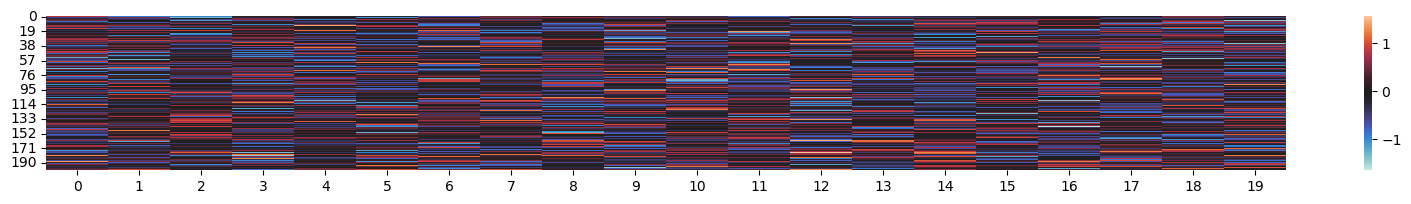

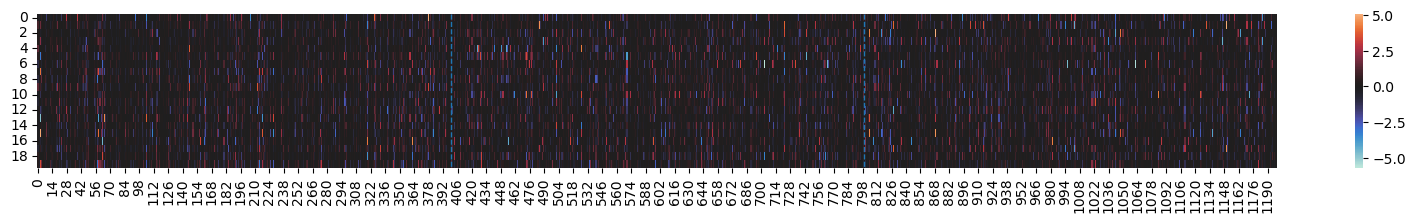

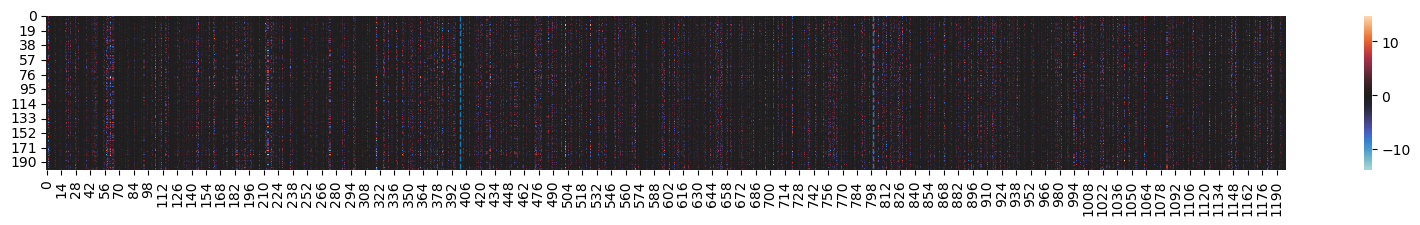

In [18]:

lined_heatmap(z_hat, vlines=vlines, center=0)
lined_heatmap(w_hat, vlines=vlines, center=0)
lined_heatmap(x_hat, vlines=vlines, center=0)
# lined_heatmap(sigma_hat[np.newaxis, :], vlines=vlines, center=0)

In [28]:
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr

from sklearn.metrics import pairwise_distances, mean_squared_error, r2_score
from sklearn.metrics import precision_recall_fscore_support, PrecisionRecallDisplay

In [29]:
r2_score(dg.y, x_hat)

0.5788883595743333

In [30]:
def get_opt_thresh(X, Y, thresh_min=0, thresh_max=1, n_thresh=101):
    thresh_max = min(thresh_max, Y.max())
    print(thresh_max)
    thresholds = np.linspace(thresh_min, thresh_max, n_thresh)
    f1s = []
    for threshold in thresholds:
        prec, rec, f1, _ = precision_recall_fscore_support(
            X.flatten(), (Y > threshold).flatten(), average="binary"
        )
        f1s.append(f1)

    return thresholds[np.argmax(f1s)]

In [31]:
opt_order = linear_sum_assignment(-np.abs(pairwise_distances(
    dg.w,
        w_hat,
        metric=lambda a, b: pearsonr(a, b)[0],
        force_all_finite=False,
    )))[-1]
opt_order

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [23]:
w_hat = w_hat[opt_order, :]
z_hat = z_hat[:, opt_order]

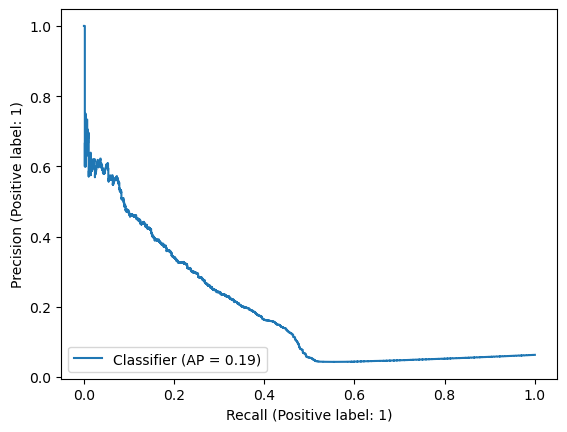

In [24]:
PrecisionRecallDisplay.from_predictions(dg.w_mask.flatten(), w_hat.flatten())

In [25]:
threshold = get_opt_thresh(
    dg.w_mask,
    w_hat,
    0,
    5,
)
threshold

5


0.9

<Axes: >

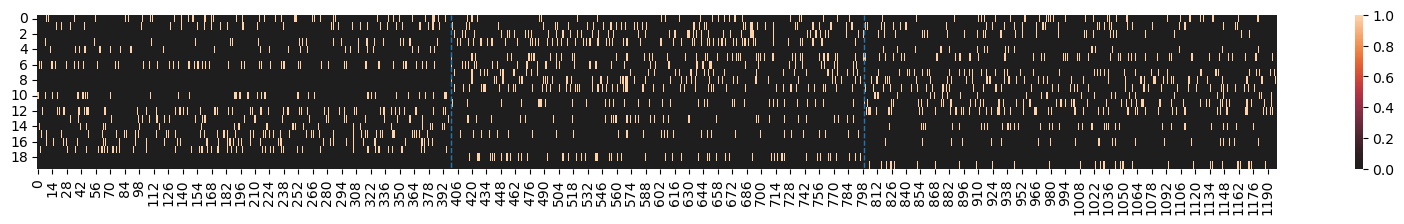

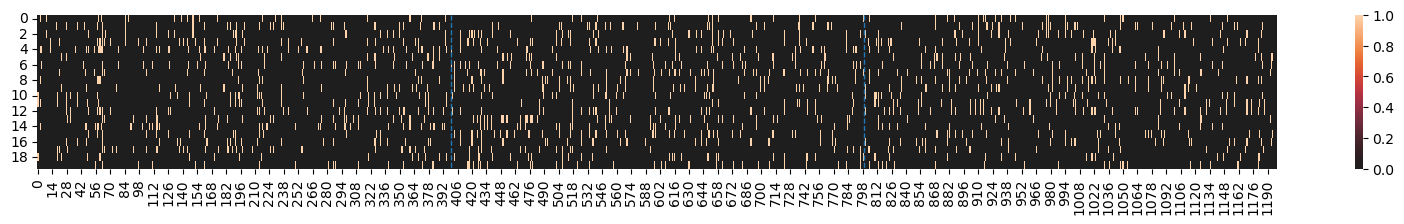

In [34]:
lined_heatmap(dg.w_mask, vlines=vlines, center=0)
lined_heatmap(w_hat > threshold, vlines=vlines, center=0)

In [26]:
precision_recall_fscore_support((dg.w_mask).flatten(), (w_hat > threshold).flatten(), average="binary")

(0.2752542372881356, 0.26763348714568225, 0.27139037433155083, None)